/content


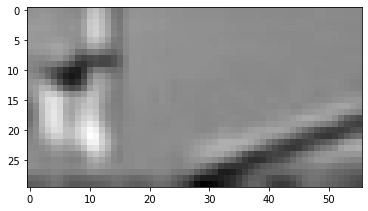

(30, 56)


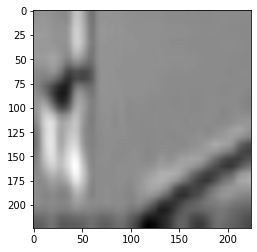

381
0
1
0
1
1
1
1
1
1
1
Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 13s 1s/step - loss: 4.9211 - accuracy: 0.6901 - val_loss: 0.5901 - val_accuracy: 0.8205
Epoch 2/10
11/11 [==============================] - 13s 1s/step - loss: 0.5146 - accuracy: 0.7456 - val_loss: 0.3189 - val_accuracy: 0.7692
Epoch 3/10
11/11 [==============================] - 13s 1s/step - loss: 0.3393 - accuracy: 0.8304 - val_loss: 0.2174 - val_accuracy: 0.8718
Epoch 4/10
11/11 [==============================] - 13s 1s/step 

In [0]:
"""
@author: siamm
"""

!pwd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2


DATADIR = "train_data/train" # set directory
CATEGORIES = ["empty", "occupied"]

for category in CATEGORIES:
  path  = os.path.join(DATADIR, category) #path to occupied & empty spots ds directory
  for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)

    plt.imshow(img_array, cmap="gray")
    plt.show()
    break
  break

# print(img_array)
print(img_array.shape)
# Need to normalize shape as img may be portrait, landscape, etc.

IMG_SIZE = 224

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap = 'gray')
plt.show()

#create training dataset

training_data = []

def create_training_data():
    for category in CATEGORIES:
      path  = os.path.join(DATADIR, category) 
      class_num = CATEGORIES.index(category)
      for img in os.listdir(path):
        try:  # to handle broken files
            img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training_data.append([new_array, class_num])
        except Exception as e:
            pass

create_training_data()
print(len(training_data))

#balance of training data: shuffle data if dataset is not 50:50 - confuses model otherwise

      # 0 = empty; 1 = occupied


import random

random.shuffle(training_data)

for sample in training_data[:10]:
    print(sample[1])

# pack it into variables that are going to be used
# X: feature set,  y: labels   train:X test:y?

X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)  #-1 indicates catch anything or any number and last 1 indicates grayscale


import pickle
from numpy import array
# save data

pickle_out = open("X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()



pickle_in = open("X.pickle", "rb")
X = pickle.load(pickle_in)

X[1]



# CNN conv : involves convolution :useful features? and pooling -over and over again
# pixel data -convolutional window -simplifies what it finds into some values; window shifts++' detailed:padding, etc
# may use convolution + max pooling:highest value
# edges ->lines ->squiggles -> circles ->squares ->... etc when it goes deeper and deeper


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import pickle

X = pickle.load(open("X.pickle", "rb"))
# y = pickle.load(open("y.pickle", "rb"))
y = array(pickle.load(open("y.pickle","rb")))

# normalize data - scale data - image - max val 255 min 0 for pixel data - so div by 255 or keras.util.normalize

X = X/255.0

model = Sequential()
model.add(Conv2D(64, (3,3), input_shape = X.shape[1:])) #num_units, window size, input shape parameters
# after convolutional layer either pass activation layer or pooling
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2,2)))

# repeat without shape
model = Sequential()
model.add(Conv2D(64, (3,3)))
# after convolutional layer either pass activation layer or pooling
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2,2)))

# now we have 2X64 convolutional neural network?
model.add(Flatten())
model.add(Dense(64)) #final dense layer of 64 nodes; it's 1D dataset so need to flatten data since convolution is 2D
model.add(Activation("relu")) #for some reason accuracy drops in some instances but using it is more proper


# output layer
model.add(Dense(1)) 
model.add(Activation('sigmoid')) #activation for it-the dense layer , or use model.add(Dense(1), activation = ???)

# can add the "layers" as an array "model = Sequential ([ flatten(), Dense(10),  Activation('relu') ])" instead of using the model.add() function every time


model.compile(loss="binary_crossentropy", 
              optimizer ="adam",
              metrics=['accuracy'])  #could also use categorical instead of binary_crossentropy but since we need only occupied or empty


# how many at a time we want to pass, 20 to 200 optimum?, may negatively impact if batch size >1000s if dataset is relatively small; depends on size of data
model.fit(X, y, batch_size=32, epochs = 10, validation_split=0.1) 

# possible optimizations to layers, epochs, param,... -sentdex:tensorboard,...

model.save('64X3-CNN.model')  # use this model for prediction -note path




# Using Trained Model

In [0]:
# To use trained model

import cv2
import tensorflow as tf

CATEGORIES = ["empty", "occupied"]

def prepare(filepath):
    IMG_SIZE = 254   #use same size as used to train model
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, 1)


model = tf.keras.models.load_model("64X3-CNN.model")

# model loaded- ready to make a prediction
prediction = model.predict([prepare('occupied1.jpg')]) # always enter a list even if singular

print(prediction) # plain ugly 


prediction = model.predict([prepare('occupied1.jpg')])
print(int(prediction[0][0]))  # pretty level 1: 0 or 1

#
# To Do: (loop through array of images - timed every x secs - return prediction for each indexed lot images ??)
#
prediction = model.predict([prepare('occupied1.jpg')])
print(CATEGORIES[int(prediction[0][0])])  # pretty level max: indicates EMPTY OR OCCUPIED


prediction = model.predict([prepare('empty1.jpg')])
print(CATEGORIES[int(prediction[0][0])])  # predicc: fed empty lot img




Deploy ML model prediction output as REST API -JSON object

---



In [0]:
from flask import Flask
from flask_restful import reqparse, abort, Api, Resource
import numpy as np
import pickle
from model import NLPModel


app = Flask(__name__)
api = Api(app)

# creating new model object
model = NLPModel()

# loading trained classifier
clf_path = 'lib/models/SentimentClassifier.pki'
with open(clf_path, 'rb') as f:
  model.clf = pickle.load(f)

# load trained vectorizer
vec_path = 'lib/models/SentimentClassifier.pki'
with open(clf_path, 'rb') as f:
  model.clf = pickle.load(f)

# load trained vectorizer
vec_path = 'lib/models/TFIDFVectorizer.pki'
with open(vec_path, 'rb') as f:
  model.vectorizer = pickle.load(f)


  # creates argument parsing 
  parser = reqparse.RequestParser()
  parser.add_argument('query')


 # ...continue segment -unfinished 
 .
 ..
 ....
 ......
 ........
 

In [0]:
# Geoevents Server--ArcGIS

# Serialization of model structure to JSON


In [0]:
# Serialization of model structure to JSON

model_json = model.to_json()
with open("model.json", "w") as json_mfile:
  json_mfile.write(model_json)

.
...
.....
.......

# Result analysis- plotting evaluation of loss and accuracy on training and validation sets --skipped/manually tried

In [0]:
# Result analysis- plotting evaluation of loss and accuracy on training and validation sets

# Confusion Matrix of the predictions

In [0]:
# confusion matrix of predictions

# computing predictions (again?)

predictions = model.

.
..
...
.....
......

#Real Time Predictions
Creating a class for predictions of model trained previously

In [0]:
# Creating a class for predictions of model trained previously

from keras.models import model_from_json
import numpy as np


class vehicleIdentificationModel(object):
  STATUS_LIST = ["Empty", "Occupied"]

  def __init__(self, model_json_file, model_weights_file):
    # loading model from JSON file
    with open(model_json_file, "r") as json_mfile:
      loaded_model_json = json_file.read()
      self.loaded_model = model_from_json(loaded_model_json)

      # loading weights into new model
      self.loaded_model.load_weights(model)
    ..
    .....
    ......

# Creating Flask app to render image predictions into Web Page

In [0]:
from flask import Flask, render_template, Response
from camera import VideoCamera

app = Flask(__name__)

@app.route('/')
def index()
    return render_template('index.html')

    def gen(camera):
      while True:
        frame = camera.get_frame()
        yield (b'--frame\r\n'
               b'Content-Type: image/jpeg\r\n\r\n' + frame + b'\r\n\r\n')
        
@app.route('/video_feed')
def video_feed():
    return Response(gen(VideoCamera())),
                  mimetype = 'multipart/x-mixed-replace; boundary=frame')

if __name__ == '__main__':
    app.run(host=0.0.0.0, debug=True)        